# SVM model

#### Importing the data

In [17]:

# @hidden_cell
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_4ce2b21ebf484e98948d2c0b81b8b84f(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'admin_c24f02ccead8f3d4baea656ecbccd8e6e38d474d','domain': {'id': '8d5c5723b93e4bdf8c5be53de58a2395'},
            'password': 'D!~GY/p7Z]b##1oV'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

data_train = pd.read_csv(get_object_storage_file_with_credentials_4ce2b21ebf484e98948d2c0b81b8b84f('seminaire_data', 'Transformed_features.csv'), index_col=False)
data_train.head()

,Unnamed: 0,installer_f,installer_fnr,extraction_type_f,extraction_type_fnr,source_f,source_fnr,waterpoint_type_group_f,waterpoint_type_group_fnr,management_f,...,scheme_management_fnr,lga_f,lga_fnr,basin_f,basin_fnr,amount_tsh,permit,age_pump,public_meeting,target
0,0,0.606383,0.074468,0.599253,0.100859,0.622290,0.074966,0.576491,0.083986,0.504234,...,0.063436,0.774823,0.019504,0.653687,0.049164,6000,0,36,1,0
1,1,0.846154,NaN,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.599540,...,0.028721,0.592179,0.037709,0.497658,0.096507,0,1,47,-1,0
2,2,0.654412,0.132353,0.599253,0.100859,0.385671,0.036585,0.576491,0.083986,0.504234,...,0.063436,0.581169,0.016234,0.600895,0.053356,25,1,46,1,0
3,3,0.536036,0.040541,0.551217,0.047649,0.489571,0.044334,0.576491,0.083986,0.504234,...,0.063436,0.265823,NaN,0.371689,0.072557,0,1,23,1,2
4,4,0.555556,0.044444,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.598341,...,NaN,0.530480,0.058366,0.497658,0.096507,0,1,-1,1,0


### Preparing the data (normalisation, splitting training and test ...)

In [18]:
data_train = data_train.iloc[:, 1:]

In [19]:
data_train.head()

,installer_f,installer_fnr,extraction_type_f,extraction_type_fnr,source_f,source_fnr,waterpoint_type_group_f,waterpoint_type_group_fnr,management_f,management_fnr,...,scheme_management_fnr,lga_f,lga_fnr,basin_f,basin_fnr,amount_tsh,permit,age_pump,public_meeting,target
0,0.606383,0.074468,0.599253,0.100859,0.622290,0.074966,0.576491,0.083986,0.504234,0.068902,...,0.063436,0.774823,0.019504,0.653687,0.049164,6000,0,36,1,0
1,0.846154,NaN,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.599540,0.099002,...,0.028721,0.592179,0.037709,0.497658,0.096507,0,1,47,-1,0
2,0.654412,0.132353,0.599253,0.100859,0.385671,0.036585,0.576491,0.083986,0.504234,0.068902,...,0.063436,0.581169,0.016234,0.600895,0.053356,25,1,46,1,0
3,0.536036,0.040541,0.551217,0.047649,0.489571,0.044334,0.576491,0.083986,0.504234,0.068902,...,0.063436,0.265823,NaN,0.371689,0.072557,0,1,23,1,2
4,0.555556,0.044444,0.599253,0.100859,0.603922,0.136819,0.576491,0.083986,0.598341,0.065166,...,NaN,0.530480,0.058366,0.497658,0.096507,0,1,-1,1,0


In [20]:
# Transforming the data into numpy arrays

Y = (data_train.target).tolist()
y = np.asarray(Y)

In [21]:
# Dropping the y column and the time column

data_train.drop('target', axis=1, inplace=True)



In [22]:
# Transforming the data frame into an array

X = data_train.as_matrix()
X.shape

# First we fill the Nan values with the mean (first approach)

X = np.where(np.isnan(X), np.ma.array(X, mask = np.isnan(X)).mean(axis=0), X)

In [23]:
# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

#Splitting the data into training and test sets (80% (includes the cross validation set) - 20%)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:((4 * X.shape[0]) / 5)], indices[((4 * X.shape[0]) / 5):]
X_train, y_train, X_test, y_test = X[train_idx,:], y[train_idx], X[test_idx,:], y[test_idx]



## SVM (Support Vector Machines)

SVM are based on the concept of decision planes in order to define decision boundaries. The goal is to find the separator hyperplane with the greatest margin and which make labeling errors. A parameter C needs to be tuned in order to adress the trade off between errors (fitting to the data) and margin (generalization ability). Here, below are example of hyperplanes generated with SVM (Kernel Trick).

<img src="http://img11.hostingpics.net/pics/901502svmfrontieres.png" alt="SVM calibration 1" style="width:300px;height:280px;">

 We have to decided to first run the code on our computers to get a first idea of optimal values for C and $\gamma$ as it is taking to much time to run on the API. Then the code bellow, present a more accurate range of $\gamma$ and C to test. 

<img src="http://img11.hostingpics.net/thumbs/mini_532590svmgamma.png" alt="SVM calibration 1" style="width:180px;height:160px;">

<img src="http://img11.hostingpics.net/thumbs/mini_993944svmgammamoreaccurate.png" alt="SVM calibration 2"  style="width:150px;height:200px;"
>


In order to display the plots

In [24]:
%matplotlib inline

0.5
1
1.5


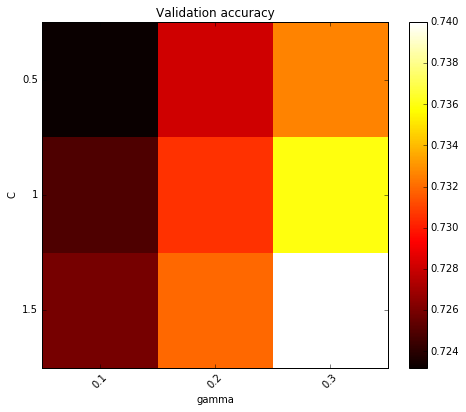

In [25]:
# Trying the SVM algorithm for classification (Kernel : RBF)

# Importing the libraries and functions

from sklearn import svm
from sklearn.cross_validation import cross_val_score
from sklearn.decomposition import PCA

#fitting the parameters for the svm classification ()

# Projecting with a PCA before to keep a reasonable amount of variables
pca = PCA(n_components = 5)
X_train = pca.fit_transform(X_train)


C_range = [0.5,1, 1.5] 
gamma_range = [0.1, 0.2, 0.3]
classifiers = []
scores = []
for C in C_range:
    print(C)
    for gamma in gamma_range:
        clf = svm.SVC(C=C, gamma=gamma)
        scores.append(cross_val_score(clf, X_train, y_train, cv=5).mean())
        

# plot the scores of the grid
# We extract just the scores
        
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()
